In [32]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from IPS import IPS
from AdaIPS_v2 import AdaIPS_S
from getData import getData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.t_losses = []
        self.v_losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [4]:
epochs = 10
batch_size = 64


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainloader, trainset, testloader, testset, validationloader, valset = getData('MNIST', transform=transform, batch_size=batch_size)

In [ ]:
def train(model, optimizer, epochs=2):
    model.train()
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

    
            # if i % 100 == 0:                
            #     with torch.no_grad():
            #         for v_i, (v_inputs, v_labels) in enumerate(validationloader):
            #             v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
            #             v_outputs = model(v_inputs)
            #             v_loss = criterion(v_outputs, v_labels)
                    
            #         print("validation loss", v_loss.item())                   
            #     model.v_losses.append(v_loss.item())
                
            loss = optimizer.step(closure)
            running_loss += loss
            
            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
                model.t_losses.append(loss.item())
        
        # model.t_losses.append(running_loss / len(trainloader.dataset))
            

    print("Training complete.")
    return model

In [35]:
def test(model):
    model.eval()
    for i, (inputs, labels) in enumerate(testloader):
        with torch.no_grad():
            output = model(inputs)
            output = output.argmax(axis=1)
        
        print(np.unique(output.detach().numpy()))
        precision, recall, fscore, _ = precision_recall_fscore_support(labels, output.detach().numpy(), average='weighted')
        print(accuracy_score(labels, output.detach().numpy()))
        print(precision, recall, fscore)
        

        precision, recall, fscore, support = precision_recall_fscore_support(labels, output, average=None)

        for i in range(10):
            print(f"Class {i} -> Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {fscore[i]:.4f}")


In [8]:
adaIpsModel = SimpleNN().to(device)
adaIpsOptimizer = AdaIPS_S(adaIpsModel.parameters(), T=epochs * (len(trainset)/batch_size), lower_bound=0, beta_1=0.9, beta_2=0.99)
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)

initialized optimizer with per layer learning rate: False
AdaIPS_S (
Parameter Group 0
    T0: 7500.0
    beta_1: 0.9
    beta_2: 0.99
    eps: 1e-08
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.320192813873291
Epoch 1, Step 100, Loss: 0.6492817997932434
Epoch 1, Step 200, Loss: 0.5493653416633606
Epoch 1, Step 300, Loss: 0.3101827800273895
Epoch 1, Step 400, Loss: 0.3226011395454407
Epoch 1, Step 500, Loss: 0.07811646908521652
Epoch 1, Step 600, Loss: 0.2869938611984253
Epoch 1, Step 700, Loss: 0.14212512969970703
Epoch 2, Step 0, Loss: 0.04254835844039917
Epoch 2, Step 100, Loss: 0.13238123059272766
Epoch 2, Step 200, Loss: 0.08843465894460678
Epoch 2, Step 300, Loss: 0.06597400456666946
Epoch 2, Step 400, Loss: 0.1308557540178299
Epoch 2, Step 500, Loss: 0.246595561504364
Epoch 2, Step 600, Loss: 0.18946707248687744
Epoch 2, Step 700, Loss: 0.14476557075977325
Epoch 3, Step 0, Loss: 0.16918528079986572
Epoch 3, Step 100, Loss: 0.07004037499427795
Epoch 3, Step 200, Loss: 0.04643495

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [16]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=epochs * (len(trainset) / batch_size), lower_bound=0)
train(ipsModel, ipsOptimizer, epochs=epochs)

IPS (
Parameter Group 0
    T: 7500.0
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.310356616973877
Epoch 1, Step 100, Loss: 0.9836260080337524
Epoch 1, Step 200, Loss: 0.6645563244819641
Epoch 1, Step 300, Loss: 0.6181482672691345
Epoch 1, Step 400, Loss: 0.5949625372886658
Epoch 1, Step 500, Loss: 0.5700258016586304
Epoch 1, Step 600, Loss: 0.6971757411956787
Epoch 1, Step 700, Loss: 0.5283675789833069
Epoch 2, Step 0, Loss: 0.33761411905288696
Epoch 2, Step 100, Loss: 0.23127035796642303
Epoch 2, Step 200, Loss: 0.4734524190425873
Epoch 2, Step 300, Loss: 0.29009875655174255
Epoch 2, Step 400, Loss: 0.2766049802303314
Epoch 2, Step 500, Loss: 0.2689449191093445
Epoch 2, Step 600, Loss: 0.2572050094604492
Epoch 2, Step 700, Loss: 0.472623348236084
Epoch 3, Step 0, Loss: 0.40171918272972107
Epoch 3, Step 100, Loss: 0.38839882612228394
Epoch 3, Step 200, Loss: 0.3905586898326874
Epoch 3, Step 300, Loss: 0.4060995280742645
Epoch 3, Step 400, Loss: 0.5728355050086975
Epoch 3, Step 500, L

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [17]:
adamModel = SimpleNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=epochs)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3169009685516357
Epoch 1, Step 100, Loss: 0.2712443172931671
Epoch 1, Step 200, Loss: 0.5892071723937988
Epoch 1, Step 300, Loss: 0.43883129954338074
Epoch 1, Step 400, Loss: 0.33936095237731934
Epoch 1, Step 500, Loss: 0.1498388946056366
Epoch 1, Step 600, Loss: 0.15637579560279846
Epoch 1, Step 700, Loss: 0.22047516703605652
Epoch 2, Step 0, Loss: 0.2031545639038086
Epoch 2, Step 100, Loss: 0.09479282796382904
Epoch 2, Step 200, Loss: 0.11505657434463501
Epoch 2, Step 300, Loss: 0.04123007506132126
Epoch 2, Step 400, Loss: 0.11447177082300186
Epoch 2, Step 500, Loss: 0.11758515238761902
Epoch 2, Step 600, Loss: 0.10588410496711731
Epoch 2, Step 700, Loss: 0.06760980933904648
Epoch 3, Step 0, Loss: 0.0706048533320427
Epoch 3, Step 100, Loss: 0

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [20]:
rmsModel = SimpleNN().to(device)
rmsOptimizer = torch.optim.RMSprop(rmsModel.parameters(), lr=1e-3)
train(rmsModel, rmsOptimizer, epochs=epochs)

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3299977779388428
Epoch 1, Step 100, Loss: 0.3675234317779541
Epoch 1, Step 200, Loss: 0.2919004559516907
Epoch 1, Step 300, Loss: 0.22073328495025635
Epoch 1, Step 400, Loss: 0.10466201603412628
Epoch 1, Step 500, Loss: 0.11671572178602219
Epoch 1, Step 600, Loss: 0.11728226393461227
Epoch 1, Step 700, Loss: 0.21559643745422363
Epoch 2, Step 0, Loss: 0.06495052576065063
Epoch 2, Step 100, Loss: 0.13826531171798706
Epoch 2, Step 200, Loss: 0.1758531928062439
Epoch 2, Step 300, Loss: 0.23695805668830872
Epoch 2, Step 400, Loss: 0.05375059321522713
Epoch 2, Step 500, Loss: 0.13425953686237335
Epoch 2, Step 600, Loss: 0.14849317073822021
Epoch 2, Step 700, Loss: 0.07436104118824005
Epoch 3, Step 0, Loss: 0.050841040909290314
Epoch 3, Step 100, Loss: 0.

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [36]:
test(adaIpsModel)
# test(ipsModel)
# test(adamModel
# test(rmsModel)

[0 1 2 3 4 5 6 7 8 9]
0.9769
0.9769956966266554 0.9769 0.9768844512871842
Class 0 -> Precision: 0.9682, Recall: 0.9949, F1-score: 0.9814
Class 1 -> Precision: 0.9921, Recall: 0.9921, F1-score: 0.9921
Class 2 -> Precision: 0.9721, Recall: 0.9806, F1-score: 0.9764
Class 3 -> Precision: 0.9808, Recall: 0.9624, F1-score: 0.9715
Class 4 -> Precision: 0.9836, Recall: 0.9756, F1-score: 0.9796
Class 5 -> Precision: 0.9669, Recall: 0.9809, F1-score: 0.9738
Class 6 -> Precision: 0.9753, Recall: 0.9875, F1-score: 0.9813
Class 7 -> Precision: 0.9900, Recall: 0.9591, F1-score: 0.9743
Class 8 -> Precision: 0.9681, Recall: 0.9671, F1-score: 0.9676
Class 9 -> Precision: 0.9692, Recall: 0.9683, F1-score: 0.9688


[2.320192813873291, 0.6492817997932434, 0.5493653416633606, 0.3101827800273895, 0.3226011395454407, 0.07811646908521652, 0.2869938611984253, 0.14212512969970703, 0.04254835844039917, 0.13238123059272766, 0.08843465894460678, 0.06597400456666946, 0.1308557540178299, 0.246595561504364, 0.18946707248687744, 0.14476557075977325, 0.16918528079986572, 0.07004037499427795, 0.046434953808784485, 0.027187777683138847, 0.0378841906785965, 0.0755678340792656, 0.014604763127863407, 0.0176897794008255, 0.020731940865516663, 0.11847377568483353, 0.1368013322353363, 0.06444714218378067, 0.051435958594083786, 0.08813756704330444, 0.03749372065067291, 0.03922117128968239, 0.01322018913924694, 0.036427807062864304, 0.05553889647126198, 0.09094386547803879, 0.02666431851685047, 0.036669161170721054, 0.07995970547199249, 0.07957211881875992, 0.0684974268078804, 0.006865018978714943, 0.005144750699400902, 0.16121365129947662, 0.003218128113076091, 0.006228503305464983, 0.04934767261147499, 0.00362175051122

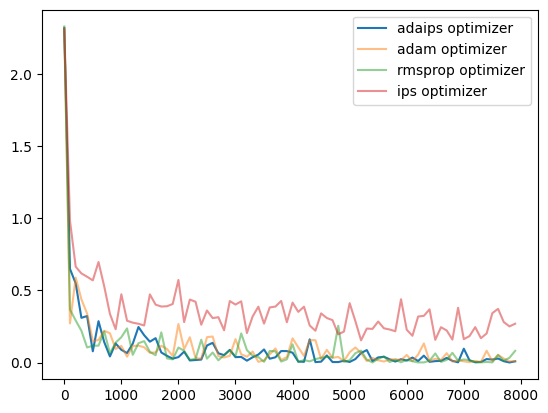

In [24]:

models = [
    (adaIpsModel, 'adaips optimizer'),
    (adamModel, 'adam optimizer'),
    (rmsModel, 'rmsprop optimizer'),
    (ipsModel, 'ips optimizer')

]
exclude = []
focus = [adaIpsModel]
interval = 1
for model, optimizer in models:
    print(model.t_losses)
    plt.plot(
        [i * 100 for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        label=optimizer,
        alpha=0.5 if model not in focus else 1
    )

plt.legend()
plt.show()

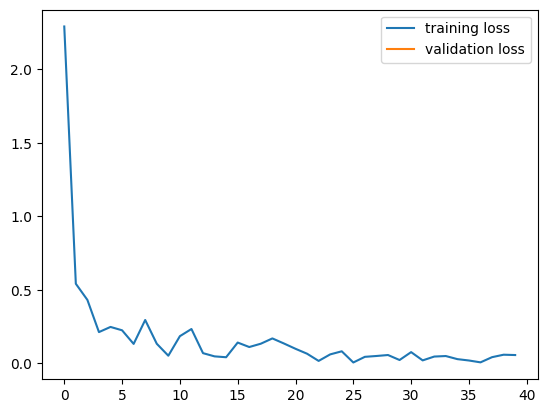

In [ ]:

plt.plot([t for t in adaIpsModel.t_losses], label='training loss')
plt.plot([v for v in adaIpsModel.v_losses], label='validation loss')
plt.legend()
plt.show()
